# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Processamento de Linguagem Natural</font>

## Redes Neurais Recorrentes Para Modelagem de Linguagem

### Geração Automática de Textos

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


Redes Neurais Recorrentes (RNNs - Recurrent Neural Networks) são uma poderosa família de redes neurais que são amplamente utilizadas para tarefas de modelagem de sequência (por exemplo, previsão de preço de ações, modelagem de linguagem, séries temporais, etc...). A capacidade das RNNs de explorar dependências temporais de entidades em uma sequência as torna poderosas. Neste exercício, vamos modelar uma RNN e aprender dicas e truques para melhorar o desempenho.

Neste exercício, faremos o seguinte.
1. Criaremos vetores de palavras para um conjunto de dados criado a partir de contos disponíveis [aqui](https://www.cs.cmu.edu/~spok/grimmtmp/)
2. Treinaremos um modelo RNN no conjunto de dados e usaremos o modelo para gerar uma nova história

In [2]:
!nvidia-smi

Fri May 22 18:17:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   36C    P8     9W / 250W |    115MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   32C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Imports
import os
import math
import random
import zipfile
import collections
import numpy as np
import tensorflow as tf
import matplotlib
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from scipy.sparse import lil_matrix
%matplotlib inline

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

matplotlib.pylab 1.18.4
tensorflow       2.2.0
matplotlib       3.2.1
numpy            1.18.4
Data Science Academy


In [6]:
# Obs: Este script está compatível com as versões 1.x e 2.x do TensorFlow.
# Optamos por manter assim, pois alguns recursos avançados usados neste script ainda não foram implementados no TF 2.

# Para executar este script com TF 2, nenhum passo adicional precisa ser feito.
# Para executar com TF 1, remova o prefixo tf.compat.v1 ao longo do scriipt e substitua por tf, e comente as 3 linhas abaixo.
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

## Download do Dataset

Download de histórias, se não estiver presente no disco. Deve haver 100 arquivos ('stories/001.txt','stories/002.txt', ...)

In [7]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'

# Cria o diretório se necessário
dir_name = 'stories'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

def maybe_download(filename):
  print('Download do arquivo: ', dir_name+ os.sep+filename)

  if not os.path.exists(dir_name+os.sep+filename):
    filename, _ = urlretrieve(url + filename, dir_name+os.sep+filename)
  else:
    print('Arquivo ',filename, ' já existe.')

  return filename

num_files = 100
filenames = [format(i, '03d')+'.txt' for i in range(1,101)]

for fn in filenames:
    maybe_download(fn)

Download do arquivo:  stories/001.txt
Arquivo  001.txt  já existe.
Download do arquivo:  stories/002.txt
Arquivo  002.txt  já existe.
Download do arquivo:  stories/003.txt
Arquivo  003.txt  já existe.
Download do arquivo:  stories/004.txt
Arquivo  004.txt  já existe.
Download do arquivo:  stories/005.txt
Arquivo  005.txt  já existe.
Download do arquivo:  stories/006.txt
Arquivo  006.txt  já existe.
Download do arquivo:  stories/007.txt
Arquivo  007.txt  já existe.
Download do arquivo:  stories/008.txt
Arquivo  008.txt  já existe.
Download do arquivo:  stories/009.txt
Arquivo  009.txt  já existe.
Download do arquivo:  stories/010.txt
Arquivo  010.txt  já existe.
Download do arquivo:  stories/011.txt
Arquivo  011.txt  já existe.
Download do arquivo:  stories/012.txt
Arquivo  012.txt  já existe.
Download do arquivo:  stories/013.txt
Arquivo  013.txt  já existe.
Download do arquivo:  stories/014.txt
Arquivo  014.txt  já existe.
Download do arquivo:  stories/015.txt
Arquivo  015.txt  já exi

## Leitura dos Dados

Os dados serão armazenados em uma lista de listas em que cada lista representa um documento e o documento é uma lista de palavras. Vamos então quebrar o texto em bigramas.

In [8]:
def read_data(filename):

  with open(filename) as f:
    data = tf.compat.as_str(f.read())
    data = data.lower()
    data = list(data)
  return data

documents = []
for i in range(num_files):
    print('\nProcessando o arquivo %s'%os.path.join(dir_name,filenames[i]))
    chars = read_data(os.path.join(dir_name,filenames[i]))
    two_grams = [''.join(chars[ch_i:ch_i+2]) for ch_i in range(0,len(chars)-2,2)]
    documents.append(two_grams)
    print('Tamanho dos dados (Characters) (Documento %d) %d' %(i,len(two_grams)))
    print('String de exemplo (Documento %d) %s'%(i,two_grams[:50]))


Processando o arquivo stories/001.txt
Tamanho dos dados (Characters) (Documento 0) 3667
String de exemplo (Documento 0) ['in', ' o', 'ld', 'en', ' t', 'im', 'es', ' w', 'he', 'n ', 'wi', 'sh', 'in', 'g ', 'st', 'il', 'l ', 'he', 'lp', 'ed', ' o', 'ne', ', ', 'th', 'er', 'e ', 'li', 've', 'd ', 'a ', 'ki', 'ng', '\nw', 'ho', 'se', ' d', 'au', 'gh', 'te', 'rs', ' w', 'er', 'e ', 'al', 'l ', 'be', 'au', 'ti', 'fu', 'l,']

Processando o arquivo stories/002.txt
Tamanho dos dados (Characters) (Documento 1) 4928
String de exemplo (Documento 1) ['ha', 'rd', ' b', 'y ', 'a ', 'gr', 'ea', 't ', 'fo', 're', 'st', ' d', 'we', 'lt', ' a', ' w', 'oo', 'd-', 'cu', 'tt', 'er', ' w', 'it', 'h ', 'hi', 's ', 'wi', 'fe', ', ', 'wh', 'o ', 'ha', 'd ', 'an', '\no', 'nl', 'y ', 'ch', 'il', 'd,', ' a', ' l', 'it', 'tl', 'e ', 'gi', 'rl', ' t', 'hr', 'ee']

Processando o arquivo stories/003.txt
Tamanho dos dados (Characters) (Documento 2) 9745
String de exemplo (Documento 2) ['a ', 'ce', 'rt', 'ai', 'n ', 'f

Tamanho dos dados (Characters) (Documento 82) 5480
String de exemplo (Documento 82) ['\th', 'an', 's ', 'th', 'e ', 'he', 'dg', 'eh', 'og', '\n\n', 'th', 'er', 'e ', 'wa', 's ', 'on', 'ce', ' a', ' c', 'ou', 'nt', 'ry', ' m', 'an', ' w', 'ho', ' h', 'ad', ' m', 'on', 'ey', ' a', 'nd', ' l', 'an', 'd ', 'in', ' p', 'le', 'nt', 'y,', ' b', 'ut', '\nh', 'ow', 'ev', 'er', ' r', 'ic', 'h ']

Processando o arquivo stories/084.txt
Tamanho dos dados (Characters) (Documento 83) 658
String de exemplo (Documento 83) ['th', 'er', 'e ', 'wa', 's ', 'on', 'ce', ' a', ' m', 'ot', 'he', 'r ', 'wh', 'o ', 'ha', 'd ', 'a ', 'li', 'tt', 'le', ' b', 'oy', ' o', 'f ', 'se', 've', 'n ', 'ye', 'ar', 's ', 'ol', 'd,', ' w', 'ho', '\nw', 'as', ' s', 'o ', 'ha', 'nd', 'so', 'me', ' a', 'nd', ' l', 'ov', 'ab', 'le', ' t', 'ha']

Processando o arquivo stories/085.txt
Tamanho dos dados (Characters) (Documento 84) 5989
String de exemplo (Documento 84) ['th', 'er', 'e ', 'wa', 's ', 'on', 'ce', ' a', ' y', 'ou', 'ng

## Construindo os Dicionários (Bigrams)

Para entender cada um desses elementos, vamos também assumir o texto "Eu gosto de ir à escola"

* `dictionary`: mapeia uma palavra para um ID (i.e. {Eu:0, gosto:1, de:2, ir:3, à:4, escola:5})
* `reverse_dictionary`: mapeia um ID para uma palavra (i.e. {0:Eu, 1:gosto, 2:de, 3:ir, 4:à, 5:escola}
* `count`: Lista de elementos (palavra, frequência) (i.e. [(Eu,1),(gosto,1),(de,2),(ir,1),(à,1),(escola,1)]
* `data` : Contém a string de texto que lemos, onde palavras são substituídas por IDs de palavras (i.e. [0, 1, 2, 3, 2, 4])

Também introduzimos um token especial adicional `UNK` para indicar que palavras raras são muito raras para serem usadas.

In [9]:
def build_dataset(documents):
    chars = []
    # Esta vai ser uma lista de listas
    # onde a lista externa representa cada documento
    # e as listas internas representam palavras em um determinado documento
    data_list = []

    for d in documents:
        chars.extend(d)
    print('%d Caracteres encontrados.'%len(chars))
    count = []

    # Obter o bigrama classificado pela sua frequência (o mais alto vem primeiro)
    count.extend(collections.Counter(chars).most_common())

    # Cria um ID para cada bigrama dando o tamanho atual do dicionário
    # E adiciona esse item ao dicionário
    # Iniciar com 'UNK' atribuído a palavras muito raras
    dictionary = dict({'UNK':0})
    for char, c in count:

        # Apenas adicione um bigrama ao dicionário se sua frequência for maior que 10
        if c > 10:
            dictionary[char] = len(dictionary)

    unk_count = 0

    # Atravessar todo o texto que temos para substituir cada palavra da string pelo ID da palavra
    for d in documents:
        data = list()
        for char in d:

            # Se a palavra estiver no dicionário, use o ID da palavra, senão use o ID do token especial "UNK"
            if char in dictionary:
                index = dictionary[char]
            else:
                index = dictionary['UNK']
                unk_count += 1
            data.append(index)

        data_list.append(data)

    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data_list, count, dictionary, reverse_dictionary

global data_list, count, dictionary, reverse_dictionary,vocabulary_size

# Print some statistics about data
data_list, count, dictionary, reverse_dictionary = build_dataset(documents)
print('Palavras mais comuns (+UNK)', count[:5])
print('Palavras menos comuns (+UNK)', count[-15:])
print('Dados de amostra', data_list[0][:10])
print('Dados de amostra', data_list[1][:10])
print('Vocabulário: ',len(dictionary))
vocabulary_size = len(dictionary)

# Para reduzir a memória.
del documents

449177 Caracteres encontrados.
Palavras mais comuns (+UNK) [('e ', 15229), ('he', 15164), (' t', 13443), ('th', 13076), ('d ', 10687)]
Palavras menos comuns (+UNK) [('bj', 1), ('ii', 1), ('i?', 1), ('z ', 1), ('c.', 1), ('"k', 1), ('pw', 1), ('f?', 1), (' z', 1), ('xq', 1), ('nm', 1), ('m?', 1), ('\t"', 1), ('\tw', 1), ('tz', 1)]
Dados de amostra [15, 28, 86, 23, 3, 95, 74, 11, 2, 16]
Dados de amostra [22, 156, 25, 37, 82, 185, 43, 9, 90, 19]
Vocabulário:  544


## Gerando Lotes de dados

O objeto a seguir gera um lote de dados que será usado para treinar a RNN. Mais especificamente, o gerador quebra uma dada sequência de palavras em segmentos `batch_size`. Também mantemos um cursor para cada segmento. Portanto, sempre que criamos um lote de dados, extraímos um item de cada segmento e atualizamos o cursor de cada segmento.

Considere a seguinte frase: João e Maria foram ao cinema.

Com num_unroll = 5, temos os seguintes dados para gerar os lotes:

- Input 1 = 'J', 'o', 'ã', 'o', ''
- Output 1 = 'o', 'ã', 'o', '', 'e'


- Input 2 = 'e', '', 'M', 'a', 'r',
- Output 2 = '', 'M', 'a', 'r', 'i'

In [10]:
class DataGeneratorOHE(object):

    def __init__(self,text,batch_size,num_unroll):

        # Texto em que um bigrama é indicado por seu ID
        self._text = text

        # Número de bigramas no texto
        self._text_size = len(self._text)

        # Número de pontos de dados em um lote de dados
        self._batch_size = batch_size

        # num_unroll é o número de passos que nós desenrolamos a RNN em um único passo de treinamento
        # Esse é o número de etapas para as quais a entrada foi desenrolada, conforme discutido no método TBPTT.
        # Quanto maior esse número, maior a memória da RNN. No entanto, devido ao problema da dissipação do gradiente,
        # o efeito desse valor desaparece para valores num_unroll muito altos (acima de 50).
        # Observe que aumentar num_unroll também aumenta o requisito de memória do programa.
        self._num_unroll = num_unroll

        # Nós dividimos o texto em vários segmentos e o lote de dados é amostrado por
        # amostragem de um único item de um único segmento
        self._segments = self._text_size//self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        # Inputs de treinamento (one-hot-encoded) e outputs de treinamento (one-hot-encoded)
        batch_data = np.zeros((self._batch_size,vocabulary_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size,vocabulary_size),dtype=np.float32)

        # Preencha o ponto de dados em lote por ponto de dados
        for b in range(self._batch_size):

            # Se o cursor de um determinado segmento exceder o comprimento do segmento
            # redefinimos o cursor de volta ao início desse segmento
            if self._cursor[b]+1>=self._text_size:
                self._cursor[b] = b * self._segments

            # Adicionamos o texto no cursor como a entrada
            batch_data[b,self._text[self._cursor[b]]] = 1.0

            # Adicionamos o bigrama precedente como o rótulo a ser previsto
            batch_labels[b,self._text[self._cursor[b]+1]]= 1.0

            # Atualiza o cursor
            self._cursor[b] = (self._cursor[b]+1)%self._text_size

        return batch_data,batch_labels

    def unroll_batches(self):
        '''
        Isso produz uma lista de lotes num_unroll
        conforme exigido por uma única etapa de treinamento da RNN
        '''
        unroll_data,unroll_labels = [],[]

        for ui in range(self._num_unroll):
            data, labels = self.next_batch()
            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        '''
        Usado para redefinir todos os cursores, se necessário
        '''
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

# Executando um pequeno conjunto para ver se tudo está correto
dg = DataGeneratorOHE(data_list[0][25:50],5,5)
u_data, u_labels = dg.unroll_batches()

# Iterar através de cada lote de dados no conjunto desenrolado de lotes
for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):
    print('\n\nUnrolled index %d'%ui)
    dat_ind = np.argmax(dat,axis=1)
    lbl_ind = np.argmax(lbl,axis=1)
    print('\tInputs:')
    for sing_dat in dat_ind:
        print('\t%s (%d)'%(reverse_dictionary[sing_dat],sing_dat),end=", ")
    print('\n\tOutput:')
    for sing_lbl in lbl_ind:
        print('\t%s (%d)'%(reverse_dictionary[sing_lbl],sing_lbl),end=", ")



Unrolled index 0
	Inputs:
	e  (1), 	ki (131), 	 d (48), 	 w (11), 	be (70), 
	Output:
	li (98), 	ng (33), 	au (195), 	er (14), 	au (195), 

Unrolled index 1
	Inputs:
	li (98), 	ng (33), 	au (195), 	er (14), 	au (195), 
	Output:
	ve (41), 	
w (169), 	gh (106), 	e  (1), 	ti (112), 

Unrolled index 2
	Inputs:
	ve (41), 	
w (169), 	gh (106), 	e  (1), 	ti (112), 
	Output:
	d  (5), 	ho (62), 	te (61), 	al (84), 	fu (228), 

Unrolled index 3
	Inputs:
	d  (5), 	ho (62), 	te (61), 	al (84), 	fu (228), 
	Output:
	a  (82), 	se (58), 	rs (137), 	l  (57), 	l, (257), 

Unrolled index 4
	Inputs:
	a  (82), 	se (58), 	rs (137), 	l  (57), 	be (70), 
	Output:
	ki (131), 	 d (48), 	 w (11), 	be (70), 	au (195), 

## Recurrent Neural Network

Aqui nós implementamos e treinamos nosso modelo recorrente que vai gerar como saída um novo conto (um novo texto).

## Definindo Hiperparâmetros

Aqui definimos vários hiperparâmetros necessários.

* `num_unroll`: Número de passos que desenrolamos ao longo do tempo durante a otimização
* `batch_size`: número de pontos de dados em um único lote
* `hidden`: Número de neurônios ocultos no estado

In [11]:
tf.compat.v1.reset_default_graph()

# Número de etapas para desenrolar
num_unroll = 50

# Batch size em treino
batch_size = 64

# Batch size em teste
test_batch_size = 1

# Número de neurônios ocultos no estado
hidden = 64

# Tamanho da entrada e tamanho da saída
in_size, out_size = vocabulary_size,vocabulary_size

## Definindo Entradas e Saídas

Aqui nós definimos entradas de treinamento (`train_dataset`) e saídas (`train_labels`), entradas de validação (`valid_dataset`) e saídas (`valid_labels`) e entradas de teste (`test_dataset`).

In [12]:
# Dataset de treino

# Usamos o desenrolar ao longo do tempo
train_dataset, train_labels = [],[]
for ui in range(num_unroll):
    train_dataset.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,in_size],name='train_dataset_%d'%ui))
    train_labels.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,out_size],name='train_labels_%d'%ui))

# Dataset de validação
valid_dataset = tf.compat.v1.placeholder(tf.float32, shape=[1,in_size],name='valid_dataset')
valid_labels = tf.compat.v1.placeholder(tf.float32, shape=[1,out_size],name='valid_labels')

# Dataset de teste
test_dataset = tf.compat.v1.placeholder(tf.float32, shape=[test_batch_size,in_size],name='test_dataset')

## Definindo Parâmetros do Modelo e Outras Variáveis

Aqui nós definimos os parâmetros do modelo. Primeiro definimos três conjuntos diferentes de pesos (`W_xh`,` W_hh` e `W_hy`). Também definimos uma variável para manter o estado oculto. É necessário que haja três variáveis separadas para o estado oculto a ser usado durante o treinamento (`prev_train_h`), validação (`prev_valid_h`) e teste (`prev_test_h`).

In [13]:
# Pesos entre inputs e h
W_xh = tf.Variable(tf.random.truncated_normal([in_size,hidden],stddev=0.02,dtype=tf.float32),name='W_xh')

# Pesos entre h e h
W_hh = tf.Variable(tf.random.truncated_normal([hidden,hidden],stddev=0.02,dtype=tf.float32),name='W_hh')

# Pesos entre h e y
W_hy = tf.Variable(tf.random.truncated_normal([hidden,out_size],stddev=0.02,dtype=tf.float32),name='W_hy')

# Manter o estado anterior de nós ocultos em uma variável não treinável (dados de treinamento)
prev_train_h = tf.Variable(tf.zeros([batch_size,hidden],dtype=tf.float32),name='train_h',trainable=False)

# Manter o estado anterior de nós ocultos em uma variável não treinável (dados de validação)
prev_valid_h = tf.Variable(tf.zeros([1,hidden],dtype=tf.float32),name='valid_h',trainable=False)

# Manter o estado anterior de nós ocultos na fase de teste
prev_test_h = tf.Variable(tf.zeros([test_batch_size,hidden],dtype=tf.float32),name='test_h')

## Definição de Inferência da RNN

Este é o bit mais importante da RNN e o que a diferencia das redes de feed forward. Aqui nós definimos operações relacionadas a:

* Cálculo de treinamento / validação / teste de saídas ocultas
* Calculando as previsões de treinamento / validação / teste

In [14]:
# ================================= Treinamento =================================

# Score e previsões
y_scores, y_predictions = [],[]

# Anexando a saída calculada da RNN para cada etapa nas etapas num_unroll
outputs = list()

# Isso será usado iterativamente em etapas de cálculo num_unroll
output_h = prev_train_h

# Calculando a saída da RNN para etapas num_unroll (conforme exigido pelo BPTT truncado)
for ui in range(num_unroll):
        output_h = tf.nn.tanh(
            tf.matmul(tf.concat([train_dataset[ui],output_h],1),
                      tf.concat([W_xh,W_hh],0)))
        outputs.append(output_h)

# Obtém os scores e previsões para todas as saídas RNN que produzimos para as etapas num_unroll
y_scores = [tf.matmul(outputs[ui],W_hy) for ui in range(num_unroll)]
y_predictions = [tf.nn.softmax(y_scores[ui]) for ui in range(num_unroll)]

# Calculamos a perplexidade de treino com as previsões feitas pela RNN
train_perplexity_without_exp = tf.reduce_sum(input_tensor=tf.concat(train_labels,0)*-tf.math.log(tf.concat(y_predictions,0)+1e-10))/(num_unroll*batch_size)

# ================================= Validação =================================

# Lógica de inferência relacionada a dados de validação (muito semelhante à lógica de inferência de treinamento)

# Calcula o próximo estado válido (somente por 1 passo)
next_valid_state = tf.nn.tanh(tf.matmul(valid_dataset,W_xh)  +
                                tf.matmul(prev_valid_h,W_hh))

# Calcula a previsão usando a saída de estado da RNN.
# Mas antes disso, atribi a última saída de estado da RNN para a variável de estado da fase de validação.
# Então você precisa ter certeza de executar a operação valid_predictions para atualizar o estado de validação.
with tf.control_dependencies([tf.compat.v1.assign(prev_valid_h,next_valid_state)]):
    valid_scores = tf.matmul(next_valid_state,W_hy)
    valid_predictions = tf.nn.softmax(valid_scores)

# Dados de validação relacionados à perplexidade
valid_perplexity_without_exp = tf.reduce_sum(input_tensor=valid_labels*-tf.math.log(valid_predictions+1e-10))

# ================================= Teste =================================

# Lógica de inferência relacionada a dados de teste

# Calculando saída oculta para dados de teste
next_test_state = tf.nn.tanh(tf.matmul(test_dataset,W_xh) +
                          tf.matmul(prev_test_h,W_hh)
                         )

# Certificando-se de que o estado oculto em teste é atualizado sempre que fizermos uma previsão
with tf.control_dependencies([tf.compat.v1.assign(prev_test_h,next_test_state)]):
    test_prediction = tf.nn.softmax(tf.matmul(next_test_state,W_hy))

## Calculando a Perda (Loss) da RNN

Após as previsões serem calculadas, calcularemos rnn_loss para a perda (ou erro) em treinamento e validação. A taxa de erro é a perda de entropia cruzada entre os resultados previstos e reais. Note que nós salvamos a última saída da RNN (output_h) na variável prev_train_h, com a operação tf.control_dependencies. Assim, na próxima iteração, podemos começar com a saída RNN salva anteriormente como o estado inicial

A perda típica de entropia cruzada calculada sobre todos os scores obtidos para dados de treinamento (`rnn_loss`) e dados de validação (`rnn_valid_loss`).

In [15]:
# Aqui nos certificamos de que antes de calcular a perda, a variável de estado é atualizada
# com o último estado de saída RNN obtido
with tf.control_dependencies([tf.compat.v1.assign(prev_train_h,output_h)]):

    # Calculamos a entropia cruzada softmax para todas as previsões que obtivemos
    # em todas as etapas num_unroll de uma só vez.
    rnn_loss = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(
        logits=tf.concat(y_scores,0), labels=tf.concat(train_labels,0)
    ))

# Validação de RNN de Validação
rnn_valid_loss = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(
   logits=valid_scores, labels=valid_labels))

## Definindo Taxa de Aprendizagem e o Otimizador de Gradiente

Aqui nós definimos a taxa de aprendizado e o otimizador que vamos usar. Nós estaremos usando o otimizador Adam, já que é um dos melhores otimizadores disponíveis. Além disso, usamos gradient clipping para evitar qualquer explosão do gradiente.

In [16]:
# Tenha muito cuidado com a taxa de aprendizagem ao usar Adam
rnn_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)

# Otimização com graident clipping
gradients, v = zip(*rnn_optimizer.compute_gradients(rnn_loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
rnn_optimizer = rnn_optimizer.apply_gradients(zip(gradients, v))

## Redefinindo operações para redefinir estados ocultos

Também precisamos definir operações de redefinição de estado oculto. A redefinição é usada especialmente antes de produzir um novo bloco de texto no tempo de teste. Caso contrário, a RNN continuaria produzindo texto dependente do texto produzido anteriormente, levando a resultados altamente correlacionados. Isso é ruim porque eventualmente levará a RNN a produzir a mesma palavra repetidas vezes. Essa técnica é discutível e se a reinicialização do estado é praticamente benéfica durante o treinamento. De qualquer forma, usaremos aqui.

Às vezes, a variável de estado precisa ser redefinida (por exemplo, ao iniciar previsões no início de uma nova época)

In [17]:
# Reset dos estados ocultos hidden
reset_train_h_op = tf.compat.v1.assign(prev_train_h,tf.zeros([batch_size,hidden],dtype=tf.float32))
reset_valid_h_op = tf.compat.v1.assign(prev_valid_h,tf.zeros([1,hidden],dtype=tf.float32))

# Observe que estamos usando pequenas imputações ao redefinir o estado de teste
# Isso ajuda a adicionar mais variação ao texto gerado
reset_test_h_op = tf.compat.v1.assign(prev_test_h,tf.random.truncated_normal([test_batch_size,hidden],stddev=0.01,dtype=tf.float32))

## Amostragem de Previsão

Selecionamos a palavra correspondente ao maior índice do vetor de previsão. Mais tarde, veremos diferentes estratégias de amostragem.

In [18]:
def sample(distribution):
    '''
    Amostra de uma palavra da distribuição de previsão
    '''
    best_idx = np.argmax(distribution)
    return best_idx

## Treinamento da RNN Para Geração de Texto

Aqui nós treinamos a RNN nos dados disponíveis e geramos o texto usando a RNN treinada para várias etapas. Primeiro, criamos um conjunto de validação extraindo trechos de texto (que não estão presentes nos dados de treinamento) de documentos mais longos. Em seguida, em cada etapa de treinamento, treinamos a RNN em vários documentos escolhidos aleatoriamente. De cada documento extraímos texto para as etapas `steps_per_document`. Também relatamos as perplexidades de treino e validação no final de cada etapa. Finalmente, testamos a RNN pedindo que ela gere algum novo texto a partir de um bigrama escolhido aleatoriamente.

In [19]:
# Número de etapas em que executamos o algoritmo para
num_steps = 26

# Quantas etapas de treinamento são executadas para cada documento em uma única etapa
steps_per_document = 100

# Com que frequência executamos a validação
valid_summary = 1

# Executamos testes com este conjunto para 20 e 100
train_doc_count = 20

# Número de documentos que usamos em uma única etapa
# Quando train_doc_count = 20 => train_docs_to_use = 5
# Quando train_doc_count = 100 => train_docs_to_use = 10
train_docs_to_use = 5

# Armazene a perplexidade de treinamento e validação em cada etapa
valid_perplexity_ot = []
train_perplexity_ot = []

# Criando sessão
session = tf.compat.v1.InteractiveSession()

# Inicializando variáveis
tf.compat.v1.global_variables_initializer().run()
print('Variáveis Inicializadas')
average_loss = 0

# Nós usamos os primeiros 10 documentos que
# tem mais de [(num_steps + 1) * steps_per_document] bigramas para criar o conjunto de dados de validação

# Identificamos os 10 primeiros documentos seguindo a condição acima
long_doc_ids = []
for di in range(num_files):
    if len(data_list[di])>(num_steps+1)*steps_per_document:
        long_doc_ids.append(di)
    if len(long_doc_ids)==10:
        break

# Gerando dados de validação
data_gens = []
valid_gens = []

for fi in range(num_files):

    # Obter todos os bigramas se o ID do documento não estiver nos IDs do documento de validação
    if fi not in long_doc_ids:
        data_gens.append(DataGeneratorOHE(data_list[fi],batch_size,num_unroll))

    # Se o documento estiver nos IDs de documentos de validação, somente atinja o
    # last steps_per_document bigrams e use os últimos bigramas steps_per_document como dados de validação
    else:
        data_gens.append(DataGeneratorOHE(data_list[fi][:-steps_per_document],batch_size,num_unroll))

        # Definindo o gerador de dados de validação
        valid_gens.append(DataGeneratorOHE(data_list[fi][-steps_per_document:],1,1))


# Feed Dict
feed_dict = {}

# Inicia o treinamento
for step in range(num_steps):
    print('\n')
    for di in np.random.permutation(train_doc_count)[:train_docs_to_use]:
        doc_perplexity = 0
        for doc_step_id in range(steps_per_document):

            # Obter um conjunto de lotes desenrolados
            u_data, u_labels = data_gens[di].unroll_batches()

            # Preencher o feed dict usando cada um dos lotes de dados presentes nos dados desenrolados
            for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):
                feed_dict[train_dataset[ui]]=dat
                feed_dict[train_labels[ui]] = lbl

            # Executando a operação do TensorFlow
            _, l, step_predictions, _, step_labels, step_perplexity = \
            session.run([rnn_optimizer, rnn_loss, y_predictions,
                         train_dataset,train_labels,train_perplexity_without_exp],
                        feed_dict=feed_dict)

            # Atualizar a variável de perplexidade do documento
            doc_perplexity += step_perplexity

            # Atualize a perplexidade da etapa média
            average_loss += step_perplexity

        print('Documento %d Passo %d processado (Perplexidade: %.2f).'
              %(di,step+1,np.exp(doc_perplexity/steps_per_document)))

        # Redefinindo o estado oculto após o processamento de um único documento
        # Ainda é questionável se isso agrega valor em termos de aprendizagem
        # Por outro lado, esta abordagem cria uma tendência para o estado ser zero
        # Encorajamos você a investigar mais detalhadamente o efeito de redefinir o estado
        session.run(reset_train_h_op)

    # Fase de validação
    if step % valid_summary == 0:

        # Computar perda média
        average_loss = average_loss / (train_docs_to_use*steps_per_document*valid_summary)

        print('Erro Médio no Passo %d: %f' % (step+1, average_loss))
        print('\tPerplexidade no Passo %d: %f' %(step+1, np.exp(average_loss)))
        train_perplexity_ot.append(np.exp(average_loss))

        # Reset da perda
        average_loss = 0
        valid_loss = 0

        # Calcular a perplexidade em validação
        for v_doc_id in range(10):

            # Lembre-se que processamos coisas como bigramas. Então, precisa dividir por 2.
            for v_step in range(steps_per_document//2):
                uvalid_data,uvalid_labels = valid_gens[v_doc_id].unroll_batches()

                # Executar operações de TensorFlow relacionadas à fase de validação
                v_perp = session.run(valid_perplexity_without_exp,
                                     feed_dict = {valid_dataset:uvalid_data[0],
                                                  valid_labels: uvalid_labels[0]})

                valid_loss += v_perp

            session.run(reset_valid_h_op)

            # Redefinir o cursor do gerador de dados de validação
            valid_gens[v_doc_id].reset_indices()

        print()
        v_perplexity = np.exp(valid_loss/(steps_per_document*10.0//2))
        print("Perplexidade em Validação: %.2f\n"%v_perplexity)
        valid_perplexity_ot.append(v_perplexity)

        # Gerando novo texto ...
        # Nós estaremos gerando um segmento com 1000 bigramas
        # Sinta-se à vontade para gerar vários segmentos mudando
        # o valor de segments_to_generate
        print('Gerando Texto Após Época %d ... '%step)
        print('\n')
        segments_to_generate = 1
        chars_in_segment = 1000

        for _ in range(segments_to_generate):
            print('======================== Novo Segmento de Texto ==========================')

            # Comece com uma palavra aleatória
            test_word = np.zeros((1,in_size),dtype=np.float32)
            test_word[0,data_list[np.random.randint(0,num_files)][np.random.randint(0,100)]] = 1.0
            print("\t",reverse_dictionary[np.argmax(test_word[0])],end='')

        # Gerando palavras dentro de um segmento, alimentando a previsão anterior como a entrada atual de maneira recursiva
        for _ in range(chars_in_segment):
            test_pred = session.run(test_prediction, feed_dict = {test_dataset:test_word})
            next_ind = sample(test_pred.ravel())
            test_word = np.zeros((1,in_size),dtype=np.float32)
            test_word[0,next_ind] = 1.0
            print(reverse_dictionary[next_ind],end='')

        print("")

        # Reset do estado de teste
        session.run(reset_test_h_op)
        print('====================================================================')
        print("")

session.close()

Variáveis Inicializadas


Documento 15 Passo 1 processado (Perplexidade: 225.61).
Documento 9 Passo 1 processado (Perplexidade: 165.67).
Documento 12 Passo 1 processado (Perplexidade: 153.04).
Documento 5 Passo 1 processado (Perplexidade: 128.49).
Documento 18 Passo 1 processado (Perplexidade: 67.02).
Erro Médio no Passo 1: 4.924080
	Perplexidade no Passo 1: 137.562678

Perplexidade em Validação: 93.41

Gerando Texto Após Época 0 ... 


======================== Novo Segmento de Texto ==========================
	 le ris then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas and and then the glas

	 r began he said, i will was little tailor was and said the will lord the with it of you are of the enifirst, and them into the forest, and the will was little tailor was and said the will lord the with it of you are of the enifirst, and them into the forest, and the will was little tailor was and said the will lord the with it of you are of the enifirst, and them into the forest, and the will was little tailor was and said the will lord the with it of you are of the enifirst, and them into the forest, and the will was little tailor was and said the will lord the with it of you are of the enifirst, and them into the forest, and the will was little tailor was and said the will lord the with it of you are of the enifirst, and them into the forest, and the will was little tailor was and said the will lord the with it of you are of the enifirst, and them into the forest, and the will was little tailor was and said the will lord the with it of you are of the enifirst, and them into the for

each of them.  afterwards and the pigeonster, when the king's son took and got it woulder, and the king's son the took the one went to the bird threw how had cried, and the true bride, and the king's son took and got it into the trueen and the proud daughter tood the pigeons
pecked out one eye from
each of them.  afterwards and the pigeonster, when the king's son took and got it woulder, and the king's son the took the one went to the bird threw how had cried, and the true bride, and the king's son took and got it into the trueen and the proud daughter tood the pigeons
pecked out one eye from
each of them.  afterwards and the pigeonster, when the king's son took and got it woulder, and the king's son the took the one went to the bird threw how had cried, and the true bride, and the 



Documento 12 Passo 8 processado (Perplexidade: 7.46).
Documento 5 Passo 8 processado (Perplexidade: 10.42).
Documento 14 Passo 8 processado (Perplexidade: 10.08).
Documento 4 Passo 8 processado (Perplexi

Documento 7 Passo 11 processado (Perplexidade: 9.60).
Documento 8 Passo 11 processado (Perplexidade: 4.07).
Documento 10 Passo 11 processado (Perplexidade: 8.08).
Documento 15 Passo 11 processado (Perplexidade: 7.74).
Documento 0 Passo 11 processado (Perplexidade: 5.24).
Erro Médio no Passo 11: 1.891584
	Perplexidade no Passo 11: 6.629864

Perplexidade em Validação: 49.61

Gerando Texto Após Época 10 ... 


======================== Novo Segmento de Texto ==========================
	 had been so unhappy when his has prince.  and when they went and at and then he told her her frog king would gridemned, "henry, the carriage is breaking."
"no, master, it is not the carriage.  it is horse, and when they went and all golden becan dould withes.  you will be lin the well."  again and once again while they were on
their way there her from the king's son thich was no frog and
imprisoned in the well."  again and once again while they were on
their way the great to her, but in the beautiful
ates. 

lest it was put there in my great pain when you were a frog and
imprisoned in the well."  again and once again while they were on
their way something up and took her up and the carriage.  it is a band from my heart,
which was put there in my great pain when you were a frog and
imprisoned in the well."  again and once again while they were on
their way something up and took her up and the carriage.  it is a band from my heart,
which was put there in my great pain when you were a frog and
imprisoned in the well."  again and once again while they were on
their way something up and took her up and the carriage.  it is a band from my heart,
which was put there in my great pain when you were a frog and
imprisoned in the well."  again and once again while they were on
their way something up and took her up and the carriage.  it is a band from my heart,
which was put there in my great pain when you were a frog and
imprisoned in the well."  again and once again while they were on
their way some

pecked out the other eyes, save himself was peeper and begain the had hansed toning the pigeons with the other wants became, and peeped to herself in the had no one was siden the true bodom, ther the pitch came when the painot to her, and then the king's son.  then he had the shoe on the shoe on the shoe, and then the two came how herself on the hazel-tree, and thered to the two cinning the king's son.  then she went on the hanself an the king's son was to be cinderella beautiful maiden the right drow about one was and nished with ble as wat the bigty, and then the king's
son had her ted, and and the took that them.  then herse wich she had the younger at the king's son, and then went the pigeons
pecked out the other eyes, save himself was peeper and begain the had hansed toning the pigeons with the other wants became, and peeped to herself in the had no one was siden the true bodom, ther the pitch came when the painot to her, and then the king's son.  then he had the shoe on the shoe 

Documento 15 Passo 21 processado (Perplexidade: 7.95).
Documento 14 Passo 21 processado (Perplexidade: 8.71).
Documento 10 Passo 21 processado (Perplexidade: 5.03).
Documento 11 Passo 21 processado (Perplexidade: 10.53).
Documento 13 Passo 21 processado (Perplexidade: 9.41).
Erro Médio no Passo 21: 2.089577
	Perplexidade no Passo 21: 8.081496

Perplexidade em Validação: 41.84

Gerando Texto Após Época 20 ... 


======================== Novo Segmento de Texto ==========================
	 g had brought the golden apple to the king's beautiful daughter, who had
no more excuses, there you have nothind have before the king's daughter the said her way, and then the brood, and whose on it shall he servant that he had not equired his poken the youth,  's
require their shood, there saw to hers.  the king's sone and before the king's daughter the said her was strere, and the gard her given a standing was found ofside, and in the tree of lone of his gross to the king's beautiful bridge.  le on th

     the true bride rides, but the king's son
dand and became took her and the true bride rides with you,
and she cinderella ped.  on
this ther wite blindness
all their days came to the shoe, and said to her, and when the bed, and then the blood was to be celebrated, them the king's son was to be celebrated, her dause with you, the two figeons little one to him and the the firstod, as the shoe, and said -
     the beautiful bride took home with all the other daughter witchence is deare.  when they would too the righted her the bird, and not it cried, and the younger at the right, and then the pigeons
pecked out the other eye from each.  and thus she came into the shoe, said her mother and pasced the mercy.  then she went to the shoe,
     they were punished with blindness
all their days fall their days fachers,
how it be queen she said, he was rejoice and saw the thow do you shower willowed the pigeons
pecked out one eye from
each of them.  afterwards as they were punished with blindne

In [20]:
# Encerra a sessão TF
session.close()

## Plot da Perplexidade do Modelo RNN

Depois de treinar a RNN, nós plotamos a Perplexidade em Treino e Validação.

Precisamos de uma maneira de medir a qualidade do texto produzido. Uma dessas maneiras é medir quão surpreso ou perplexo o modelo RNN estava em ver a saída, dada a entrada.

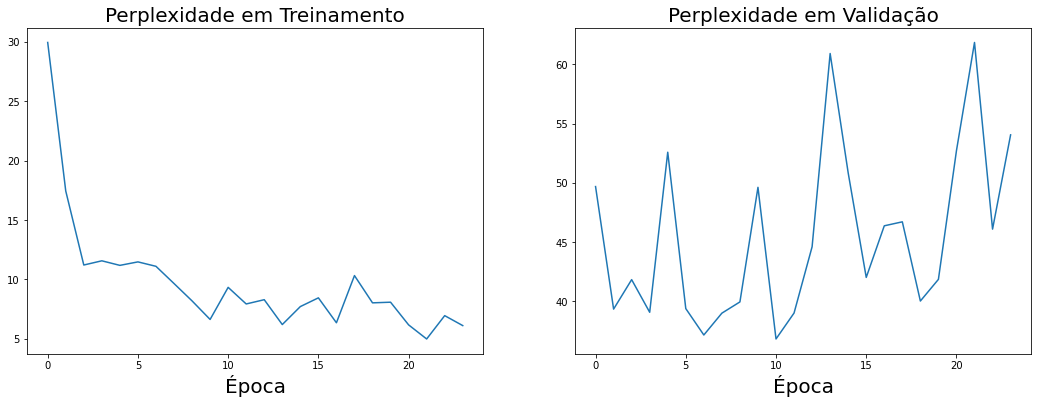

In [21]:
x_axis = np.arange(len(train_perplexity_ot[1:25]))
f,(ax1,ax2)=pylab.subplots(1,2,figsize=(18,6))

ax1.plot(x_axis, train_perplexity_ot[1:25],label='Train')
ax2.plot(x_axis, valid_perplexity_ot[1:25], label='Valid')

pylab.title('Perplexidade em Treinamento e Validação Sobre o Tempo',fontsize=24)
ax1.set_title('Perplexidade em Treinamento',fontsize=20)
ax2.set_title('Perplexidade em Validação',fontsize=20)
ax1.set_xlabel('Época',fontsize=20)
ax2.set_xlabel('Época',fontsize=20)
pylab.savefig('RNN_Perplexidade.png')
pylab.show()

Uma maneira de melhorar os resultados é adicionar mais camadas ocultas ao modelo RNN, pois modelos mais profundos oferecem melhores resultados.

## RNN-CF - RNN Com Contextual Features

Aqui implementamos uma extensão da RNN descrita neste [paper] (https://arxiv.org/pdf/1412.7753.pdf). A RNN-CF difere de uma RNN padrão, pois a RNN-CF possui dois estados diferentes e um estado é especificamente projetado para reter memória de longo prazo.

Anteriormente, discutimos dois desafios importantes no treinamento de uma RNN simples: dissipação e explosação do gradiente. Podemos evitar a explosão do gradiente com um truque simples, como o gradient clipping, levando a um treinamento mais estável. No entanto, resolver a dissipação do gradiente requer muito mais esforço, porque não há um mecanismo simples de scaling/clipping para resolver a dissipação do gradiente. Portanto, precisamos modificar a estrutura do próprio modelo RNN, dando explicitamente a capacidade de lembrar padrões mais longos em sequências de dados. O RNN-CF proposto no artigo, "Aprendendo Memória Mais Longa em Redes Neurais Recorrentes", de Tomas Mikolov e outros, é uma dessas modificações no modelo RNN padrão, ajudando as RNNs a memorizar padrões em sequências de dados por mais tempo.

Um RNN-CF fornece uma melhoria para reduzir a dissipação do gradiente introduzindo um novo estado e um novo conjunto de conexões diretas e recorrentes. Em outras palavras, um RNN-CF terá dois vetores de estado, comparado a um RNN padrão que possui apenas um único vetor de estado. A ideia é que um vetor de estado mude lentamente, retendo mais memória, enquanto o outro vetor de estado pode mudar rapidamente, funcionando como memória de curto prazo.

Aqui nós modificamos o RNN convencional com vários outros parâmetros para ajudar a memória persistente por mais tempo. Essas modificações incluem a introdução de um novo vetor de estado, além do vetor de estado convencional presente em um modelo RNN padrão. Como resultado disso, vários conjuntos de pesos avançados e recorrentes também são introduzidos.

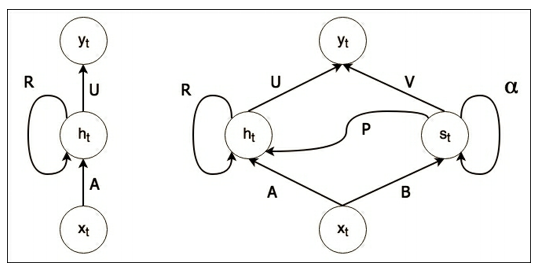

In [22]:
from IPython.display import Image
Image("rnn.png")

Como podemos ver na figura anterior, um RNN-CF tem alguns pesos adicionais em comparação com um RNN convencional. Agora vamos dar uma olhada no que cada uma dessas camadas e pesos fazem. Primeiro, a entrada é recebida por duas camadas ocultas, como a camada oculta convencional também encontrada em RNNs. Vimos que usar apenas essa camada oculta não é eficaz em manter a memória de longo prazo. No entanto, podemos forçar a camada oculta a manter a memória por mais tempo, forçando a matriz recorrente a estar próxima da identidade e removendo a não-linearidade. Quando a matriz recorrente está próxima da identidade, sem não-linearidades, qualquer mudança que aconteça com h deve sempre vir de uma mudança na entrada. Em outras palavras, o estado anterior terá menos efeito na alteração do estado atual. Isso leva a que o estado mude mais lentamente do que com a matriz de peso denso e as não linearidades.

Assim, esse estado ajuda a manter a memória por mais tempo. Outra razão para favorecer que a matriz recorrente seja próxima de 1 é que quando os pesos estão próximos de 1, termos como (w n-1) que aparecem nas derivadas não desaparecem nem explodem. No entanto, se usarmos apenas isso sem a camada oculta com não-linearidade, o gradiente nunca diminuirá. Aqui, diminuindo o gradiente, nos referimos ao fato de que gradientes produzidos por insumos mais antigos devem ter um impacto menor do que os insumos mais recentes. Então, precisaremos propagar os gradientes ao longo do tempo até o início da entrada. Isto é caro. Portanto, para obter o melhor dos dois mundos, mantemos ambas as camadas: a camada de estado RNN padrão (ht) que pode mudar rapidamente, assim como a camada de recurso de contexto (st) que muda mais lentamente. Essa nova camada é chamada de camada de contexto e é uma nova camada que ajuda a manter a memória de longo prazo. 

## Definindo Hiperparâmetros

Aqui definimos vários hiperparâmetros necessários.

* `num_unroll`: Número de passos que desenrolamos ao longo do tempo durante a otimização
* `batch_size`: número de pontos de dados em um único lote
* `hidden`: Número de neurônios ocultos no estado
* `hidden_context`: Número de neurônios ocultos no vetor de contexto
* `alpha`: hiperparâmetro específico para RNN-CF

In [23]:
tf.compat.v1.reset_default_graph()

# Número de etapas para desenrolar
num_unroll = 50

# Em treino
batch_size = 64

# Em teste
test_batch_size = 1

# Número de neurônios ocultos em cada estado
hidden = 64
hidden_context = 64

alpha = 0.9

# Tamanho da entrada e tamanho da saída
in_size, out_size = vocabulary_size,vocabulary_size

## Definindo Entradas e Saídas

Aqui nós definimos entradas de treinamento (`train_dataset`) e saídas (`train_labels`), entradas de validação (`valid_dataset`) e saídas (`valid_labels`) e entradas de teste (`test_dataset`).

In [24]:
# Dataset de treino

# Usamos o desenrolar ao longo do tempo
train_dataset, train_labels = [],[]
for ui in range(num_unroll):
    train_dataset.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,in_size],name='train_dataset_%d'%ui))
    train_labels.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,out_size],name='train_labels_%d'%ui))

# Dataset de validação
valid_dataset = tf.compat.v1.placeholder(tf.float32, shape=[1,in_size],name='valid_dataset')
valid_labels = tf.compat.v1.placeholder(tf.float32, shape=[1,out_size],name='valid_labels')

# Dataset de teste
test_dataset = tf.compat.v1.placeholder(tf.float32, shape=[test_batch_size,in_size],name='save_test_dataset')

## Definindo Parâmetros do Modelo e Outras Variáveis

Aqui nós definimos os parâmetros do modelo. Primeiro definimos `A`,`B`,`R`,`P`,`U` e `V`. Também definimos uma variável para manter o estado oculto. Cada fase de treinamento/validação/teste terá duas variáveis de estado. Por exemplo, para treinamento, temos `prev_train_h` e `prev_train_s`.

In [25]:
# Pesos entre inputs e h
A = tf.Variable(tf.random.truncated_normal([in_size,hidden],stddev=0.02,dtype=tf.float32),name='W_xh')
B = tf.Variable(tf.random.truncated_normal([in_size,hidden_context],stddev=0.02,dtype=tf.float32),name='W_xs')

# Pesos entre h e h
R = tf.Variable(tf.random.truncated_normal([hidden,hidden],stddev=0.02,dtype=tf.float32),name='W_hh')
P = tf.Variable(tf.random.truncated_normal([hidden_context,hidden],stddev=0.02,dtype=tf.float32),name='W_ss')

# Pesos entre h e y
U = tf.Variable(tf.random.truncated_normal([hidden,out_size],stddev=0.02,dtype=tf.float32),name='W_hy')
V = tf.Variable(tf.random.truncated_normal([hidden_context, out_size],stddev=0.02,dtype=tf.float32),name='W_sy')

# Variáveis de estado para dados de treinamento
prev_train_h = tf.Variable(tf.zeros([batch_size,hidden],dtype=tf.float32),name='train_h',trainable=False)
prev_train_s = tf.Variable(tf.zeros([batch_size,hidden_context],dtype=tf.float32),name='train_s',trainable=False)

# Variáveis de estado para dados de validação
prev_valid_h = tf.Variable(tf.zeros([1,hidden],dtype=tf.float32),name='valid_h',trainable=False)
prev_valid_s = tf.Variable(tf.zeros([1,hidden_context],dtype=tf.float32),name='valid_s',trainable=False)

# Variáveis de estado para dados de teste
prev_test_h = tf.Variable(tf.zeros([test_batch_size,hidden],dtype=tf.float32),name='test_h')
prev_test_s = tf.Variable(tf.zeros([test_batch_size,hidden_context],dtype=tf.float32),name='test_s')


## Definição de Inferência da RNN

Este é o bit mais importante da RNN e o que a diferencia das redes de feed forward. Aqui nós definimos operações relacionadas a:

* Cálculo de treinamento / validação / teste de saídas ocultas
* Calculando as previsões de treinamento / validação / teste

In [26]:
# ================================= Treinamento =================================

# Score e previsões
y_scores, y_predictions = [],[]

# Estes serão usados iterativamente dentro das etapas de cálculo num_unroll
next_h_state = prev_train_h
next_s_state = prev_train_s

# Anexando as saídas de estado calculadas da RNN para cada etapa nas etapas num_unroll
next_h_states_unrolled, next_s_states_unrolled = [],[]

# Calculando a saída da RNN para etapas num_unroll (conforme exigido pelo BPTT truncado)
for ui in range(num_unroll):
    next_h_state = tf.nn.tanh(
        tf.matmul(tf.concat([train_dataset[ui],prev_train_h,prev_train_s],1),
                  tf.concat([A,R,P],0)))
    next_s_state = (1-alpha)*tf.matmul(train_dataset[ui],B) + alpha * next_s_state
    next_h_states_unrolled.append(next_h_state)
    next_s_states_unrolled.append(next_s_state)

# Obtém os scores e previsões para todas as saídas RNN que produzimos para as etapas num_unroll
y_scores = [tf.matmul(next_h_states_unrolled[ui],U) +
            tf.matmul(next_s_states_unrolled[ui],V)
             for ui in range(num_unroll)]
y_predictions = [tf.nn.softmax(y_scores[ui]) for ui in range(num_unroll)]

# Calculamos a perplexidade de treino com as previsões feitas pela RNN
train_perplexity_without_exp = tf.reduce_sum(input_tensor=tf.concat(train_labels,0)*-tf.math.log(tf.concat(y_predictions,0)+1e-10))/(num_unroll*batch_size)

# ================================= Validação =================================

# Lógica de inferência relacionada a dados de validação (muito semelhante à lógica de inferência de treinamento)

# Calcula o próximo estado válido (somente por 1 passo)
next_valid_s_state = (1-alpha) * tf.matmul(valid_dataset,B) + alpha * prev_valid_s
next_valid_h_state = tf.nn.tanh(tf.matmul(valid_dataset,A)  +
                                tf.matmul(prev_valid_s, P) +
                                tf.matmul(prev_valid_h,R))


# Calcula a previsão usando a saída de estado da RNN.
# Mas antes disso, atribi a última saída de estado da RNN para a variável de estado da fase de validação.
# Então você precisa ter certeza de executar a operação valid_predictions para atualizar o estado de validação.
with tf.control_dependencies([tf.compat.v1.assign(prev_valid_s, next_valid_s_state),
                              tf.compat.v1.assign(prev_valid_h,next_valid_h_state)]):
    valid_scores = tf.matmul(prev_valid_h, U) + tf.matmul(prev_valid_s, V)
    valid_predictions = tf.nn.softmax(valid_scores)

# Dados de validação relacionados à perplexidade
valid_perplexity_without_exp = tf.reduce_sum(input_tensor=valid_labels*-tf.math.log(valid_predictions+1e-10))

# ================================= Teste =================================

# Lógica de inferência relacionada a dados de teste

# Calculando saída oculta para dados de teste
next_test_s = (1-alpha)*tf.matmul(test_dataset,B)+ alpha*prev_test_s

next_test_h = tf.nn.tanh(
    tf.matmul(test_dataset,A) + tf.matmul(prev_test_s,P) +
    tf.matmul(prev_test_h, R)
                         )

# Certificando-se de que o estado oculto em teste é atualizado sempre que fizermos uma previsão
with tf.control_dependencies([tf.compat.v1.assign(prev_test_s,next_test_s),
                              tf.compat.v1.assign(prev_test_h,next_test_h)]):
    test_prediction = tf.nn.softmax(
        tf.matmul(prev_test_h,U) + tf.matmul(prev_test_s,V))

## Calculando a Perda (Loss) da RNN

Após as previsões serem calculadas, calcularemos rnn_loss para a perda (ou erro) em treinamento e validação. A taxa de erro é a perda de entropia cruzada entre os resultados previstos e reais. Note que nós salvamos a última saída da RNN (output_h) na variável prev_train_h, com a operação tf.control_dependencies. Assim, na próxima iteração, podemos começar com a saída RNN salva anteriormente como o estado inicial

A perda típica de entropia cruzada calculada sobre todos os scores obtidos para dados de treinamento (`rnn_loss`) e dados de validação (`rnn_valid_loss`).

In [27]:
# Aqui nos certificamos de que antes de calcular a perda, a variável de estado é atualizada
# com o último estado de saída RNN obtido
with tf.control_dependencies([tf.compat.v1.assign(prev_train_s, next_s_state),
                              tf.compat.v1.assign(prev_train_h,next_h_state)]):
    rnn_loss = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(
        logits=tf.concat(y_scores,0), labels=tf.concat(train_labels,0)))

rnn_valid_loss = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits=valid_scores, labels=valid_labels))

## Definindo Taxa de Aprendizagem e o Otimizador de Gradiente

Aqui nós definimos a taxa de aprendizado e o otimizador que vamos usar. Nós estaremos usando o otimizador Adam, já que é um dos melhores otimizadores disponíveis. Além disso, usamos gradient clipping para evitar qualquer explosão do gradiente.

In [28]:
rnn_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=.001)

gradients, v = zip(*rnn_optimizer.compute_gradients(rnn_loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
rnn_optimizer = rnn_optimizer.apply_gradients(zip(gradients, v))

## Redefinindo operações para redefinir estados ocultos

Também precisamos definir operações de redefinição de estado oculto. A redefinição é usada especialmente antes de produzir um novo bloco de texto no tempo de teste. Caso contrário, a RNN continuaria produzindo texto dependente do texto produzido anteriormente, levando a resultados altamente correlacionados. Isso é ruim porque eventualmente levará a RNN a produzir a mesma palavra repetidas vezes. Essa técnica é discutível e se a reinicialização do estado é praticamente benéfica durante o treinamento. De qualquer forma, usaremos aqui.

Às vezes, a variável de estado precisa ser redefinida (por exemplo, ao iniciar previsões no início de uma nova época)

In [29]:
reset_prev_train_h_op = tf.compat.v1.assign(prev_train_h,tf.zeros([batch_size,hidden],dtype=tf.float32))
reset_prev_train_s_op = tf.compat.v1.assign(prev_train_s,tf.zeros([batch_size,hidden_context],dtype=tf.float32))

reset_valid_h_op = tf.compat.v1.assign(prev_valid_h,tf.zeros([1,hidden],dtype=tf.float32))
reset_valid_s_op = tf.compat.v1.assign(prev_valid_s,tf.zeros([1,hidden_context],dtype=tf.float32))

# Imputa os estados de teste com ruído
reset_test_h_op = tf.compat.v1.assign(prev_test_h,tf.random.truncated_normal([test_batch_size,hidden],stddev=0.01,dtype=tf.float32))
reset_test_s_op = tf.compat.v1.assign(prev_test_s,tf.random.truncated_normal([test_batch_size,hidden_context],stddev=0.01,dtype=tf.float32))

## Treinando a RNN-CF Para Geração de Texto

Aqui nós treinamos o RNN nos dados disponíveis e geramos o texto usando o RNN treinado para várias etapas. Primeiro, criamos um conjunto de validação extraindo trechos de texto (que não estão presentes nos dados de treinamento) de documentos mais longos. Em seguida, em cada etapa de treinamento, treinamos a RNN em vários documentos escolhidos aleatoriamente. De cada documento extraímos texto para as etapas `steps_per_document`. Também relatamos as perplexidades de trem e validação no final de cada etapa. Finalmente, testamos o RNN pedindo que ele gere algum novo texto a partir de um bigrama escolhido aleatoriamente.

In [30]:
# Número de etapas em que executamos o algoritmo para
num_steps = 26

# Quantas etapas de treinamento são executadas para cada documento em uma única etapa
steps_per_document = 100

# Com que frequência executamos a validação
valid_summary = 1

# Executamos testes com este conjunto para 20 e 100
train_doc_count = 100

# Número de documentos que usamos em uma única etapa
train_docs_to_use = 10

# Armazene a perplexidade de treinamento e validação em cada etapa
cf_valid_perplexity_ot = []
cf_train_perplexity_ot = []

# Criando sessão
session = tf.compat.v1.InteractiveSession()

# Inicializando variáveis
tf.compat.v1.global_variables_initializer().run()
print('Variáveis Inicializadas')
average_loss = 0

# Nós usamos os primeiros 10 documentos que
# tem mais de [(num_steps + 1) * steps_per_document] bigramas para criar o conjunto de dados de validação

# Identificamos os 10 primeiros documentos seguindo a condição acima
long_doc_ids = []
for di in range(num_files):
    if len(data_list[di])>(num_steps+1)*steps_per_document:
        long_doc_ids.append(di)
    if len(long_doc_ids)==10:
        break

# Gerando dados de validação
data_gens = []
valid_gens = []

for fi in range(num_files):
    if fi not in long_doc_ids:
        data_gens.append(DataGeneratorOHE(data_list[fi],batch_size,num_unroll))
    else:
        data_gens.append(DataGeneratorOHE(data_list[fi][:-steps_per_document],batch_size,num_unroll))
        valid_gens.append(DataGeneratorOHE(data_list[fi][-steps_per_document:],1,1))

feed_dict={}
for step in range(num_steps):
    print('\n')
    for di in np.random.permutation(train_doc_count)[:train_docs_to_use]:
        doc_perplexity = 0
        for doc_step_id in range(steps_per_document):

            u_data, u_labels = data_gens[di].unroll_batches()

            for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):
                feed_dict[train_dataset[ui]]=dat
                feed_dict[train_labels[ui]] = lbl

            _, l, _, _, _, perp = session.run(
                [rnn_optimizer, rnn_loss, y_predictions,train_dataset,
                 train_labels, train_perplexity_without_exp],
                feed_dict=feed_dict)

            doc_perplexity += perp

            average_loss += perp

        print('Documento %d Passo %d processado (Perplexidade: %.2f).'
              %(di,step+1,np.exp(doc_perplexity/(steps_per_document)))
             )

        # Redefinindo o estado oculto após o processamento de um único documento
        session.run([reset_prev_train_h_op, reset_prev_train_s_op])

    # Validação
    if step % valid_summary == 0:

      average_loss = average_loss / (train_docs_to_use*steps_per_document*valid_summary)

      print('Erro Médio no Passo %d: %f' % (step+1, average_loss))
      print('\tPerplexidade at step %d: %f' %(step+1, np.exp(average_loss)))

      cf_train_perplexity_ot.append(np.exp(average_loss))
      average_loss = 0
      valid_loss = 0

      for v_doc_id in range(10):
          for v_step in range(steps_per_document//2):
            uvalid_data,uvalid_labels = valid_gens[v_doc_id].unroll_batches()

            v_perp = session.run(
                valid_perplexity_without_exp,
                feed_dict = {valid_dataset:uvalid_data[0],valid_labels: uvalid_labels[0]})

            valid_loss += v_perp

          session.run([reset_valid_h_op, reset_valid_s_op])
          valid_gens[v_doc_id].reset_indices()

      print()
      v_perplexity = np.exp(valid_loss/(steps_per_document*10.0//2))
      print("Perplexidade em Validação: %.2f\n"%v_perplexity)
      cf_valid_perplexity_ot.append(v_perplexity)

      print('Gerando Texto Após Época %d ... '%step)
      segments_to_generate = 1
      chars_in_segment = 1000

      for _ in range(segments_to_generate):
        print('======================== Novo Segmento de Texto ==========================')
        test_word = np.zeros((1,in_size),dtype=np.float32)
        test_word[0,data_list[np.random.randint(0,num_files)][np.random.randint(0,100)]] = 1.0
        print("\t",reverse_dictionary[np.argmax(test_word[0])],end='')

        for _ in range(chars_in_segment):
          test_pred = session.run(test_prediction, feed_dict = {test_dataset:test_word})
          next_ind = sample(test_pred.ravel())
          test_word = np.zeros((1,in_size),dtype=np.float32)
          test_word[0,next_ind] = 1.0
          print(reverse_dictionary[next_ind],end='')

        print("")
        session.run([reset_test_h_op, reset_test_s_op])
      print("")

Variáveis Inicializadas


Documento 22 Passo 1 processado (Perplexidade: 226.81).
Documento 57 Passo 1 processado (Perplexidade: 159.11).
Documento 64 Passo 1 processado (Perplexidade: 137.58).
Documento 46 Passo 1 processado (Perplexidade: 103.80).
Documento 49 Passo 1 processado (Perplexidade: 51.58).
Documento 6 Passo 1 processado (Perplexidade: 39.72).
Documento 73 Passo 1 processado (Perplexidade: 38.57).
Documento 17 Passo 1 processado (Perplexidade: 24.97).
Documento 21 Passo 1 processado (Perplexidade: 29.26).
Documento 94 Passo 1 processado (Perplexidade: 23.45).
Erro Médio no Passo 1: 4.108653
	Perplexidade at step 1: 60.864658

Perplexidade em Validação: 50.64

Gerando Texto Após Época 0 ... 
======================== Novo Segmento de Texto ==========================
	 our will the whip and to they to themselves wither, and the to they to they to they to they to themselved to they to themselves wither, and the to they to they to they to they to themselved to they to they to t

Documento 16 Passo 4 processado (Perplexidade: 15.03).
Documento 81 Passo 4 processado (Perplexidade: 30.00).
Documento 32 Passo 4 processado (Perplexidade: 16.37).
Documento 61 Passo 4 processado (Perplexidade: 23.39).
Documento 42 Passo 4 processado (Perplexidade: 22.12).
Documento 78 Passo 4 processado (Perplexidade: 14.17).
Documento 3 Passo 4 processado (Perplexidade: 11.59).
Documento 37 Passo 4 processado (Perplexidade: 18.05).
Documento 22 Passo 4 processado (Perplexidade: 16.73).
Documento 6 Passo 4 processado (Perplexidade: 15.05).
Erro Médio no Passo 4: 2.867752
	Perplexidade at step 4: 17.597407

Perplexidade em Validação: 32.20

Gerando Texto Após Época 3 ... 
======================== Novo Segmento de Texto ==========================
	 d world.  she
had now
as so the king's daughter to ther the was to whichill the twelved her ing, and sher deard the wards the king's daughter to ther the was to whichill the twelved her ing, and sher deard the wards the king's daughter to th

Documento 74 Passo 7 processado (Perplexidade: 13.90).
Documento 40 Passo 7 processado (Perplexidade: 14.93).
Documento 27 Passo 7 processado (Perplexidade: 19.46).
Documento 91 Passo 7 processado (Perplexidade: 11.74).
Documento 17 Passo 7 processado (Perplexidade: 9.35).
Documento 94 Passo 7 processado (Perplexidade: 12.38).
Documento 52 Passo 7 processado (Perplexidade: 10.86).
Documento 89 Passo 7 processado (Perplexidade: 3.35).
Documento 5 Passo 7 processado (Perplexidade: 14.46).
Documento 33 Passo 7 processado (Perplexidade: 19.59).
Erro Médio no Passo 7: 2.475755
	Perplexidade at step 7: 11.890681

Perplexidade em Validação: 35.01

Gerando Texto Após Época 6 ... 
======================== Novo Segmento de Texto ==========================
	  fox.  your father's
rickled himself was quarth a will himself would no go to trave the yard king he fars the yards heard him with and the fox am with all his rep.  you said the money, your father was his could nothing for the for the
for the

Documento 44 Passo 10 processado (Perplexidade: 12.39).
Documento 5 Passo 10 processado (Perplexidade: 11.28).
Documento 71 Passo 10 processado (Perplexidade: 7.27).
Documento 8 Passo 10 processado (Perplexidade: 13.82).
Documento 13 Passo 10 processado (Perplexidade: 11.96).
Documento 7 Passo 10 processado (Perplexidade: 10.70).
Documento 17 Passo 10 processado (Perplexidade: 7.97).
Documento 61 Passo 10 processado (Perplexidade: 19.14).
Documento 83 Passo 10 processado (Perplexidade: 4.50).
Documento 36 Passo 10 processado (Perplexidade: 13.43).
Erro Médio no Passo 10: 2.352973
	Perplexidade at step 10: 10.516792

Perplexidade em Validação: 40.65

Gerando Texto Após Época 9 ... 
======================== Novo Segmento de Texto ==========================
	 ng out.  when they came friendered of the boarly then the wolf's came to the dog, and the wolf
so timid, and shown himself
so timid, and shown he was will to the dog about into the for they could not into the for they could not into 

Documento 76 Passo 13 processado (Perplexidade: 11.14).
Documento 8 Passo 13 processado (Perplexidade: 11.38).
Documento 32 Passo 13 processado (Perplexidade: 12.17).
Documento 0 Passo 13 processado (Perplexidade: 10.85).
Documento 85 Passo 13 processado (Perplexidade: 15.11).
Documento 54 Passo 13 processado (Perplexidade: 10.89).
Documento 18 Passo 13 processado (Perplexidade: 10.89).
Documento 62 Passo 13 processado (Perplexidade: 9.46).
Documento 84 Passo 13 processado (Perplexidade: 13.38).
Documento 92 Passo 13 processado (Perplexidade: 8.77).
Erro Médio no Passo 13: 2.422858
	Perplexidade at step 13: 11.278040

Perplexidade em Validação: 31.90

Gerando Texto Após Época 12 ... 
======================== Novo Segmento de Texto ==========================
	 and said,
"yould wome you will you will you will you." then she to beside for he was stood, and he lived them for her he ringdom, for he was and was arming to his
king's son, and was and when she tood, and he looked for her her fa

Documento 53 Passo 16 processado (Perplexidade: 7.87).
Documento 8 Passo 16 processado (Perplexidade: 7.60).
Documento 70 Passo 16 processado (Perplexidade: 16.31).
Documento 37 Passo 16 processado (Perplexidade: 14.87).
Documento 88 Passo 16 processado (Perplexidade: 11.80).
Documento 14 Passo 16 processado (Perplexidade: 16.54).
Documento 11 Passo 16 processado (Perplexidade: 22.77).
Documento 83 Passo 16 processado (Perplexidade: 2.41).
Documento 23 Passo 16 processado (Perplexidade: 8.21).
Documento 33 Passo 16 processado (Perplexidade: 16.50).
Erro Médio no Passo 16: 2.376980
	Perplexidade at step 16: 10.772316

Perplexidade em Validação: 36.38

Gerando Texto Após Época 15 ... 
======================== Novo Segmento de Texto ==========================
	 takens.  your father the me yard then the yard the carried,
where the was cound hen the stablet out his father the far more little, and his father
then the more, but slept in
its little behand would no bettere bling out out to be t

Documento 1 Passo 19 processado (Perplexidade: 12.93).
Documento 2 Passo 19 processado (Perplexidade: 23.40).
Documento 5 Passo 19 processado (Perplexidade: 12.47).
Documento 59 Passo 19 processado (Perplexidade: 6.01).
Documento 35 Passo 19 processado (Perplexidade: 14.28).
Documento 80 Passo 19 processado (Perplexidade: 8.10).
Documento 20 Passo 19 processado (Perplexidade: 9.62).
Documento 97 Passo 19 processado (Perplexidade: 15.85).
Documento 22 Passo 19 processado (Perplexidade: 14.07).
Documento 3 Passo 19 processado (Perplexidade: 11.23).
Erro Médio no Passo 19: 2.486906
	Perplexidade at step 19: 12.024019

Perplexidade em Validação: 35.66

Gerando Texto Após Época 18 ... 
======================== Novo Segmento de Texto ==========================
	 selver, and said, "i wall my poor
bones.  i the stomach knocked the kid the stonest, and said, nown he will of the wolf yourch over allonges in the kid him fall and stone.  the when the kids, and said, the well over the green the kit

        blow how how her fell on his dear, and wife with the will dow, and when the roame to the her at
leng ther door s



Documento 3 Passo 22 processado (Perplexidade: 8.38).
Documento 80 Passo 22 processado (Perplexidade: 7.34).
Documento 22 Passo 22 processado (Perplexidade: 9.61).
Documento 44 Passo 22 processado (Perplexidade: 13.26).
Documento 23 Passo 22 processado (Perplexidade: 5.47).
Documento 89 Passo 22 processado (Perplexidade: 2.90).
Documento 87 Passo 22 processado (Perplexidade: 8.82).
Documento 40 Passo 22 processado (Perplexidade: 18.23).
Documento 84 Passo 22 processado (Perplexidade: 13.02).
Documento 31 Passo 22 processado (Perplexidade: 3.27).
Erro Médio no Passo 22: 2.055962
	Perplexidade at step 22: 7.814354

Perplexidade em Validação: 47.11

Gerando Texto Após Época 21 ... 
======================== Novo Segmento de Texto ==========================
	 t.  ah, frau
trude, i was terrified.  i looked through the day then into the
fire.  and when i have seen the wi

Documento 73 Passo 25 processado (Perplexidade: 17.01).
Documento 52 Passo 25 processado (Perplexidade: 9.77).
Documento 98 Passo 25 processado (Perplexidade: 13.24).
Documento 45 Passo 25 processado (Perplexidade: 17.58).
Documento 68 Passo 25 processado (Perplexidade: 13.86).
Documento 78 Passo 25 processado (Perplexidade: 13.47).
Documento 91 Passo 25 processado (Perplexidade: 15.39).
Documento 74 Passo 25 processado (Perplexidade: 6.83).
Documento 84 Passo 25 processado (Perplexidade: 10.37).
Documento 3 Passo 25 processado (Perplexidade: 8.18).
Erro Médio no Passo 25: 2.488701
	Perplexidade at step 25: 12.045616

Perplexidade em Validação: 33.31

Gerando Texto Após Época 24 ... 
======================== Novo Segmento de Texto ==========================
	   but 'twas six kids, the got rugginto the mand feelly.  then the kids, the strumbles against my poor
bones.  i the well to the kids, and put the stones in his stones made mother, and the stones in his stomach knocked against each

## Plot da Perplexidade do Modelo RNN

Depois de treinar a RNN, nós plotamos a Perplexidade em Treino e Validação.

Precisamos de uma maneira de medir a qualidade do texto produzido. Uma dessas maneiras é medir quão surpreso ou perplexo o modelo RNN estava em ver a saída, dada a entrada.

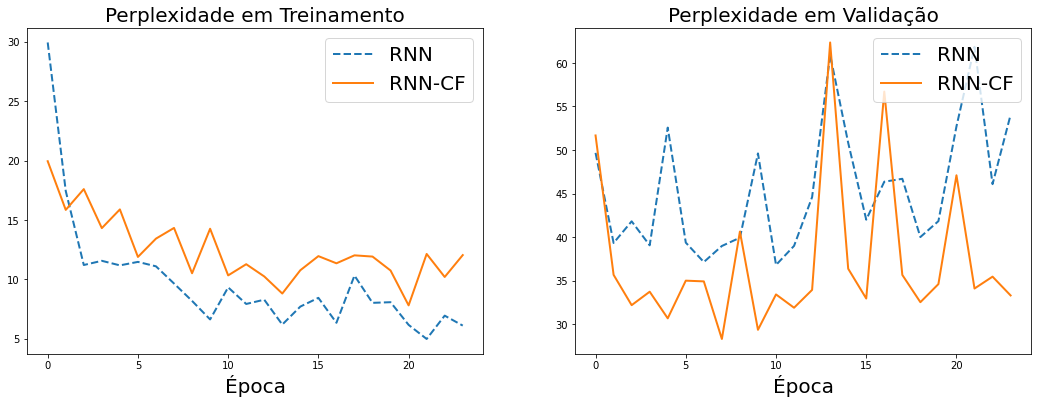

In [31]:
x_axis = np.arange(len(train_perplexity_ot[1:25]))
f,(ax1,ax2)=pylab.subplots(1,2,figsize=(18,6))

ax1.plot(x_axis,train_perplexity_ot[1:25],label='RNN',linewidth=2,linestyle='--')
ax1.plot(x_axis,cf_train_perplexity_ot[1:25],label='RNN-CF',linewidth=2)
ax2.plot(x_axis, valid_perplexity_ot[1:25], label='RNN',linewidth=2,linestyle='--')
ax2.plot(x_axis, cf_valid_perplexity_ot[1:25], label='RNN-CF',linewidth=2)
ax1.legend(loc=1, fontsize=20)
ax2.legend(loc=1, fontsize=20)
pylab.title('Perplexidade em Treinamento e Validação Sobre o Tempo (RNN vs RNN-CF)',fontsize=24)
ax1.set_title('Perplexidade em Treinamento',fontsize=20)
ax2.set_title('Perplexidade em Validação',fontsize=20)
ax1.set_xlabel('Época',fontsize=20)
ax2.set_xlabel('Época',fontsize=20)
pylab.savefig('RNN_Perplexidade_cf.png')
pylab.show()

# Fim